In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

In [2]:
# Load the S&P 500 index data
tickers = yf.Tickers('^GSPC')
tickers.tickers['^GSPC'].info
yf.download(['^GSPC'], period='6mo')

/var/folders/by/bn5byyk92gq6f173m_jc7qym0000gn/T/ipykernel_6801/225399374.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  yf.download(['^GSPC'], period='6mo')
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,
2025-01-02,5868.549805,5935.089844,5829.529785,5903.259766,3621680000
2025-01-03,5942.470215,5949.339844,5888.660156,5891.069824,3667340000
2025-01-06,5975.379883,6021.040039,5960.009766,5982.810059,4940120000
2025-01-07,5909.029785,6000.680176,5890.680176,5993.259766,4517330000
2025-01-08,5918.250000,5927.890137,5874.779785,5910.660156,4441740000
...,...,...,...,...,...
2025-06-24,6092.180176,6101.759766,6059.250000,6061.209961,5443690000
2025-06-25,6092.160156,6108.509766,6080.089844,6104.229980,5171110000


In [6]:
def load_data():
    df = yf.download("^GSPC", start="2024-01-01", end="2024-12-31")['Close'].values.reshape(-1, 1)
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df)
    return scaled_data, scaler

data, scaler = load_data()


/var/folders/by/bn5byyk92gq6f173m_jc7qym0000gn/T/ipykernel_6801/3938198723.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("^GSPC", start="2024-01-01", end="2024-12-31")['Close'].values.reshape(-1, 1)
[*********************100%***********************]  1 of 1 completed


In [7]:
def create_directional_sequences(data, seq_length=60):
    X, y = [], []
    for i in range(seq_length, len(data) - 1):
        X.append(data[i - seq_length:i])
        label = 1 if data[i + 1] > data[i] else 0
        y.append(label)
    return np.array(X), np.array(y)

X, y = create_directional_sequences(data)


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)


In [9]:
def build_classifier(input_shape):
    model = Sequential([
        SimpleRNN(50, activation='relu', input_shape=input_shape),
        Dense(1, activation='sigmoid')  # sigmoid for binary classification
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = build_classifier((X.shape[1], X.shape[2]))


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [10]:
model.fit(X_train, y_train, epochs=10, batch_size=32)


Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5819 - loss: 0.6830  
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5576 - loss: 0.6894
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5593 - loss: 0.6916
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5558 - loss: 0.6907
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5524 - loss: 0.6914
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5810 - loss: 0.6830
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5971 - loss: 0.6783
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5866 - loss: 0.6814
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5654 - loss: 0.6842
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5702 - loss: 0.6824


In [11]:
# Take the most recent 60-day window
latest_sequence = data[-60:].reshape(1, 60, 1)

# Predict probability of "up"
prob_up = model.predict(latest_sequence)[0][0]

# Interpret result
direction = "UP" if prob_up > 0.5 else "DOWN"
print(f"Prediction for tomorrow: {direction} (probability: {prob_up:.2f})")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Prediction for tomorrow: UP (probability: 0.58)


In [13]:
y_probs = model.predict(X_test).flatten()
y_pred = (y_probs > 0.5).astype(int)  # Convert probabilities to 0/1


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


In [14]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Accuracy
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

# Detailed Report
print(classification_report(y_test, y_pred, target_names=["Down", "Up"]))

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.56
              precision    recall  f1-score   support

        Down       0.00      0.00      0.00        25
          Up       0.56      1.00      0.72        32

    accuracy                           0.56        57
   macro avg       0.28      0.50      0.36        57
weighted avg       0.32      0.56      0.40        57

Confusion Matrix:
[[ 0 25]
 [ 0 32]]


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


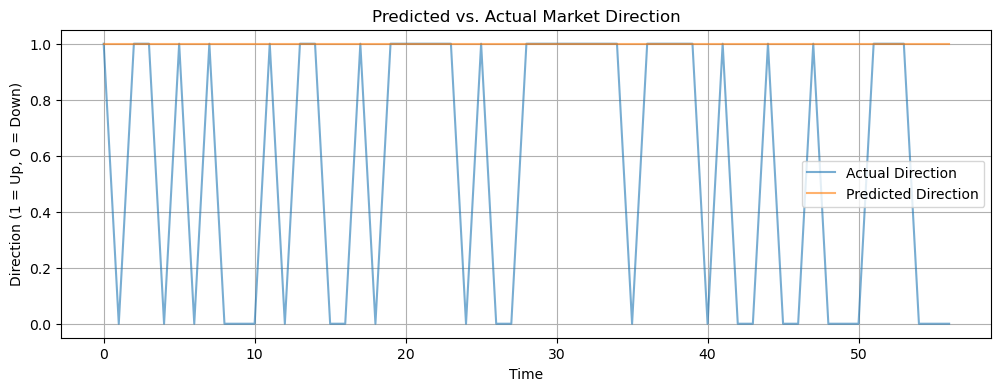

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(y_test, label='Actual Direction', alpha=0.6)
plt.plot(y_pred, label='Predicted Direction', alpha=0.6)
plt.title("Predicted vs. Actual Market Direction")
plt.xlabel("Time")
plt.ylabel("Direction (1 = Up, 0 = Down)")
plt.legend()
plt.grid(True)
plt.show()
